<a href="https://colab.research.google.com/github/Aquib88raza/image-classification-ANKLE/blob/main/cnn_for_ankle_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
# @title PROJECT LABEL

# Project:

# Tools: Python --version
#        PyThorch - ANN library for Python

# README:

# Dataset:

# Usefull infos:
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0265949

In [128]:
# @title IMPORTS

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from numpy import save
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
import matplotlib.pyplot as p
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
# @title DEFINITIONS

# Set device to use GPU if available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define transforms for data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define a series of image transforms for data augmentation and normalization.
num_epoch = 5
batch_size = 1
batch_size_testing = 1
k_folds = 8

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)
results = {}


# Classes based on images
classes = ('healthy', 'ill')

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()


In [130]:
# @title IMPORTING NAMES OF FILES FROM FOLDERS

# PATH to files
path = "/content/drive/MyDrive/Image_classificiation/Y2022Ankle"

# Define ImageFolder datasets for training and testing sets
dataset = torchvision.datasets.ImageFolder(root=path, transform=transform)
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

print(dataset)
print(dataset_loader)



Dataset ImageFolder
    Number of datapoints: 178
    Root location: /content/drive/MyDrive/Image_classificiation/Y2022Ankle
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [131]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)         #from 224 x 224
        self.conv2 = nn.Conv2d(6, 10, 5)
        self.conv3 = nn.Conv2d(10, 14, 5)
        self.conv4 = nn.Conv2d(14, 20, 5)       #to 10 x 10

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(20*10*10, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 20)
        self.fc4 = nn.Linear(20, 3)

    def forward(self, x):
        #print(x.shape)

        #x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        #x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        #x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(x)

        #x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        #x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = x.view(-1, 20*10*10)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [132]:
# @title train_and_evaluate_model

def train_and_evaluate_model(net, train_loader, val_loader, criterion, optimizer, device):
    net.to(device)
    net.train()

    for epoch in range(num_epoch):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate and print the average loss for this epoch
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

    net.eval()
    val_predictions, val_labels = [], []
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)

            val_predictions.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_predictions)
    return val_accuracy


Fold 1
Epoch 1, Loss: 0.9369970771574205
Epoch 2, Loss: 0.828978717711664
Epoch 3, Loss: 0.7745615924558332
Epoch 4, Loss: 0.7454001080605291
Epoch 5, Loss: 0.7282225635743911
[[15  0]
 [ 8  0]]
Fold 2
Epoch 1, Loss: 0.9968496114976945
Epoch 2, Loss: 0.8486892207976311
Epoch 3, Loss: 0.7825687354610812
Epoch 4, Loss: 0.7451360940933227
Epoch 5, Loss: 0.7220981184513339
[[13  0]
 [10  0]]
Fold 3
Epoch 1, Loss: 1.0050880977740655
Epoch 2, Loss: 0.8252579084573648
Epoch 3, Loss: 0.7549708655629402
Epoch 4, Loss: 0.7185702236034931
Epoch 5, Loss: 0.69852697963898
[[11  0]
 [11  0]]
Fold 4
Epoch 1, Loss: 1.0067626448013844
Epoch 2, Loss: 0.8334238907465568
Epoch 3, Loss: 0.765885054300993
Epoch 4, Loss: 0.731975818100648
Epoch 5, Loss: 0.7126445105442634
[[11  0]
 [11  0]]
Fold 5
Epoch 1, Loss: 1.0868709767476106
Epoch 2, Loss: 0.8937212866850388
Epoch 3, Loss: 0.8154796973252908
Epoch 4, Loss: 0.773808519809674
Epoch 5, Loss: 0.7473501757933543
[[17  0]
 [ 5  0]]
Fold 6
Epoch 1, Loss: 0.98

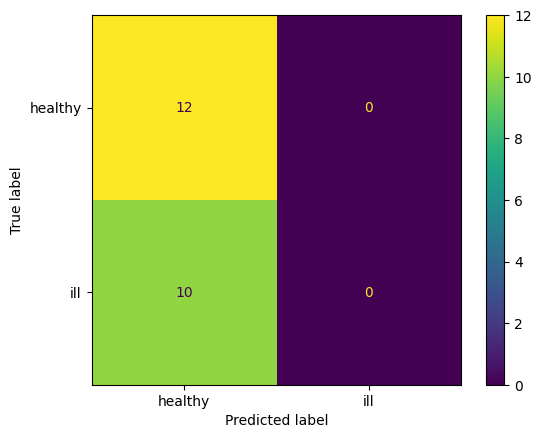


Classification Report:
              precision    recall  f1-score   support

     healthy       0.55      1.00      0.71        12
         ill       0.00      0.00      0.00        10

    accuracy                           0.55        22
   macro avg       0.27      0.50      0.35        22
weighted avg       0.30      0.55      0.39        22

--------------------
Mean Accuracy: 0.6294466403162056
Variance of Accuracy: 0.011979760658657378


In [133]:
# @title CNN IN USEAGE

# Loop over each fold and train the model
for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f"Fold {fold+1}")
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    print(train_sampler)
    print(val_sampler)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=0)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size_testing, sampler=val_sampler, num_workers=0)
    print(train_loader)
    print(val_loader)

    net = Net()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    # Train and evaluate the model
    val_accuracy = train_and_evaluate_model(net, train_loader, val_loader, criterion, optimizer, device)

    # Save the results for this fold
    results[fold + 1] = val_accuracy

    # Calculate and print the confusion matrix and classification report for this fold
    val_predictions, val_labels = [], []
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)

            val_predictions.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(val_labels, val_predictions)
    print(cm)
    c_r = classification_report(val_labels, val_predictions, target_names=classes, zero_division=0)

print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["healthy","ill"])
disp.plot()
p.show()
print()

print("Classification Report:")
print(c_r)
print("--------------------")

# Calculate and print the mean accuracy and variance of all folds
accuracies = np.array(list(results.values()))
print("Mean Accuracy:", np.mean(accuracies))
print("Variance of Accuracy:", np.var(accuracies))


